# Research Project PSB

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import math
import random
%matplotlib inline

rng = np.random.default_rng()

## Recreating the CD44s/ZEB1 feedback loop model from Jia et al., 2017 "Distinguishing mechanisms underlying EMT tristability"(https://doi.org/10.1186/s41236-017-0005-8)

In [2]:
#Defining the model function
def model(y, t, params):
    
    #Current concentrations of each dynamic component of the model (starts off as \
    #the initial concentration when the function is called)
    μ_200, m_Z, Z, m_E, E = y
    
    #Fixed parameters of the model
    (g_μ200, k_μ200, g_mZ, k_mZ, g_Z, k_Z, g_mE, k_mE, g_E, k_E,
     λ_Z_μ200, n_Z_μ200, Z0_μ200, λ_S_μ200, n_S_μ200, S0_μ200,
     λ_S_mZ, n_S_mZ, S0_mZ, μ0, n_μ200,
     λ_Z_mE, n_Z_mE, Z0_mE, λ_Cs_mZ, n_Cs_mZ, Cs0_mZ,
     n_E_Cs, E_Cs_0, S, C_T, rates) = params
    
    #Shifted hill function
    def H(B, B0, n, λ):
        return (1 + λ*(B/B0)**n) / (1 + (B/B0)**n)
    
    #Function for calculating translation rate, mRNA active degradation rate, and \
    #microRNA active degrataion rate
    def Y(μ, n, l):
        rate = 0
        
        #Looping through each number of binding sites occupied (including 0)
        for i in range(n+1):
            
            #Summation of the total rate, taking into account the rate at each \
            #number of binding sites and combinations of the binding sites
            rate += l[i] * math.comb(n, i) * (μ/μ0)**i
            
        #Returning the total rate summed
        return rate / (1 + (μ/μ0)**n)
    
    #Calculating amount of CD44s dependent on ESRP1 protein levels
    def Cs(e):
        return C_T / (1 + (e/E_Cs_0)**n_E_Cs)
    
    dydt = np.empty(len(y))
    #mircoRNA miR-200 
    dydt[0] = g_μ200 * H(Z, Z0_μ200, n_Z_μ200, λ_Z_μ200) * H(S, S0_μ200, n_S_μ200, \
              λ_S_μ200) - m_Z * Y(μ_200, n_μ200, rates[0]) - k_μ200 * μ_200
    #ZEB1 mRNA 
    dydt[1] = g_mZ * H(S, S0_mZ, n_S_mZ, λ_S_mZ) * H(Cs(E), Cs0_mZ, n_Cs_mZ, \
              λ_Cs_mZ) - m_Z * Y(μ_200, n_μ200, rates[1]) - k_mZ * m_Z
    #ZEB1 protein 
    dydt[2] = g_Z * m_Z * Y(μ_200, n_μ200, rates[2]) - k_Z * Z
    #ESRP1 mRNA 
    dydt[3] = g_mE * H(Z, Z0_mE, n_Z_mE, λ_Z_mE) - k_mE * m_E
    #ESRP1 protein 
    dydt[4] = g_E * m_E - k_E * E
    
    return dydt

### Plotting variable number of molecues over time

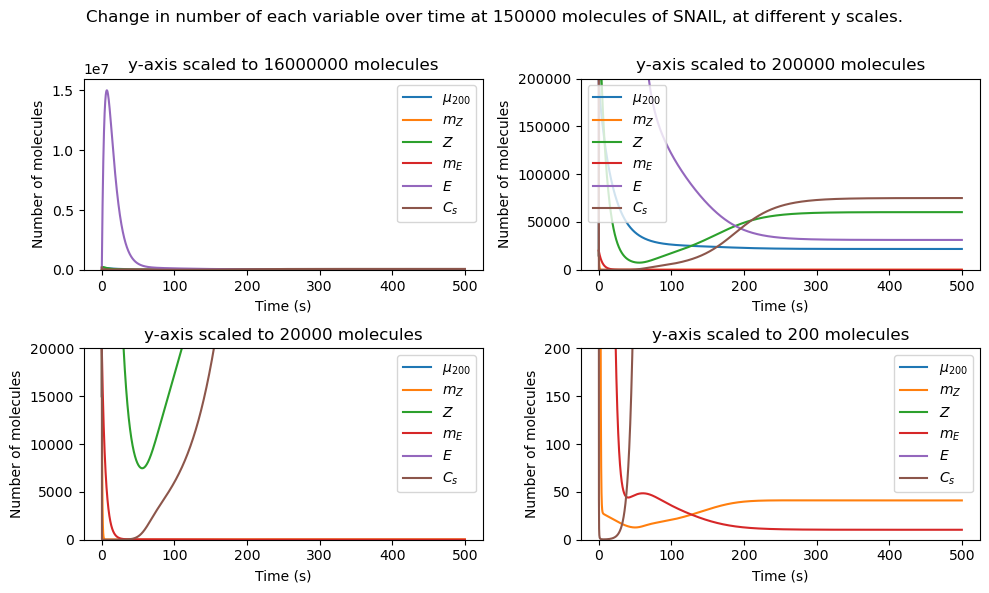

In [3]:
#Setting the initial number of molecules of the variables: μ_200, m_Z, Z, m_E, E
y0 = [200000, 20000, 15000, 20000, 15000]
#Choosing 10000 time points over 500 seconds total
t = np.linspace(0, 500, 10000)

#Initial guess matrix after some manual experimentation:
# rates_matrix = [[1, 1, 1, 0, 1, 1, 1],
#                 [0, 0, 0, 0, 0, 1, 1],
#                 [1, 1, 1, 0, 1, 1, 1]]

#The final matrix of degradation & translation rate parameters (dependent on \
#miR-200 and ZEB1 complex) optimised from below
rates_matrix = [[0.2072836 , 0.00531038, 0.21246182, 0.45427178, 0.58466384, \
        0.68420842, 0.45821863],
       [0.3521301 , 0.25882117, 0.29449745, 0.67784164, 1.36551406, \
        1.10574912, 0.86266633],
       [1.12367425, 0.6145642 , 0.52844913, 0.16996539, 0.1007383 , \
        0.07068439, 0.20191021]]
#Joining all parameters given from the paper's supplementary file as well as \
#the optimised rates matrix: g_μ200, k_μ200, g_mZ, k_mZ, g_Z, k_Z, g_mE, k_mE, \
#g_E, k_E, λ_Z_μ200, n_Z_μ200, Z0_μ200, λ_S_μ200, n_S_μ200, S0_μ200, λ_S_mZ, \
#n_S_mZ, S0_mZ, μ0, n_μ200, λ_Z_mE, n_Z_mE, Z0_mE, λ_Cs_mZ, n_Cs_mZ, Cs0_mZ, \
#n_E_Cs, E_Cs_0, S, C_T, rates
params = [2100, 0.05, 11, 0.5, 100, 0.1, 11, 0.2, 300, 0.1, 0.1, 3, 220000, \
          0.1, 2, 180000, 10, 2, 180000, 10000, 6, 0.1, 2, 20000, 10, 1, 20000, \
          2, 15000, 150000, 400000, rates_matrix]

#Solves the differential equations in the model function over the time \
#specified to achieve concentrations of each variable at each time point
concs = odeint(model, y0, t, args=(params,))

#Plotting the concentration of each variable over time
plt.figure(figsize=(10,6))
#Setting the y-axis scale for each subplot
zoom = [16000000, 200000, 20000, 200]
for i in range(4):
    plt.subplot(2,2,i+1)
    #miR-200
    plt.plot(t, concs[:,0], label="$μ_{200}$")
    #ZEB1 mRNA
    plt.plot(t, concs[:,1], label="$m_Z$")
    #ZEB1 protein
    plt.plot(t, concs[:,2], label="$Z$")
    #ESRP1 mRNA
    plt.plot(t, concs[:,3], label="$m_E$")
    #ESRP1 protein
    plt.plot(t, concs[:,4], label="$E$")
    #CD44s protein
    plt.plot(t, 400000 / (1 + (concs[:,4]/15000)**2), label="$C_s$")
    plt.legend()
    plt.ylim(0,zoom[i])
    plt.xlabel("Time (s)")
    plt.ylabel("Number of molecules")
    plt.title(f"y-axis scaled to {zoom[i]} molecules")

plt.suptitle(f"Change in number of each variable over time at {params[-3]} \
molecules of SNAIL, at different y scales.")
plt.tight_layout()
plt.show()

### Plotting bifurcation diagram

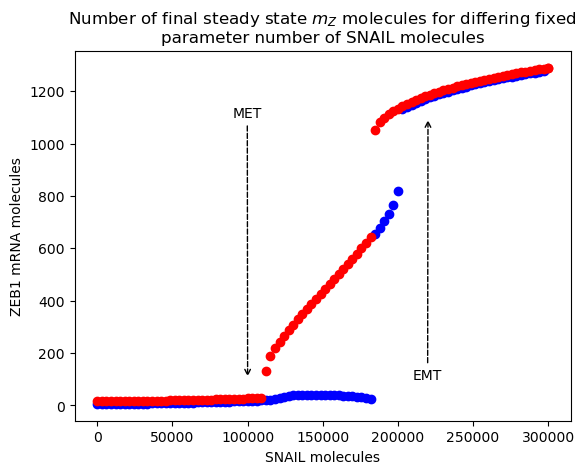

In [4]:
#Setting the amount of SNAIL molecules to increase from 0 to 300000 and back \
#down to simulate EMT followed by MET
SNAIL = np.concatenate((np.linspace(0,300000,100), np.linspace(300000,0,100)))

plt.figure()
colour = "blue"
#Introducing a shift to be able to more clearly see the overlapping data points
shift = 0
for s in SNAIL:
    #Resetting the amount of SNAIL molecules in the parameter list
    params[-3] = s
    y = odeint(model, y0, t, args=(params,))
    #Extracting the final number of molecules of ZEB1 mRNA at the steady state at \
    #500 seconds
    mZ = y[:,1][-1]
    #Updating the new "initial" number of molecules of the variables
    y0 = y[-1]
    #Changing colour of the plotted dots to identify when EMT is switching to MET
    if s == 300000:
        colour = "red"
        #Making the shift bigger than 0 to more clearly see the overlapping data \
        #points
        shift = 10
    plt.plot(s, mZ+shift, 'o', color = colour)
plt.xlabel("SNAIL molecules")
plt.ylabel("ZEB1 mRNA molecules")
plt.annotate('EMT', xy=(220000, 1100), xytext=(210000, 100), \
             arrowprops=dict(arrowstyle='->', linestyle='dashed'))
plt.annotate('MET', xy=(100000, 100), xytext=(90000, 1100), \
             arrowprops=dict(arrowstyle='->', linestyle='dashed'))
plt.title("Number of final steady state $m_Z$ molecules for differing fixed \
\nparameter number of SNAIL molecules")
plt.show()

### Identifying the three steady states over varying number of molecules of ZEB1 mRNA and protein

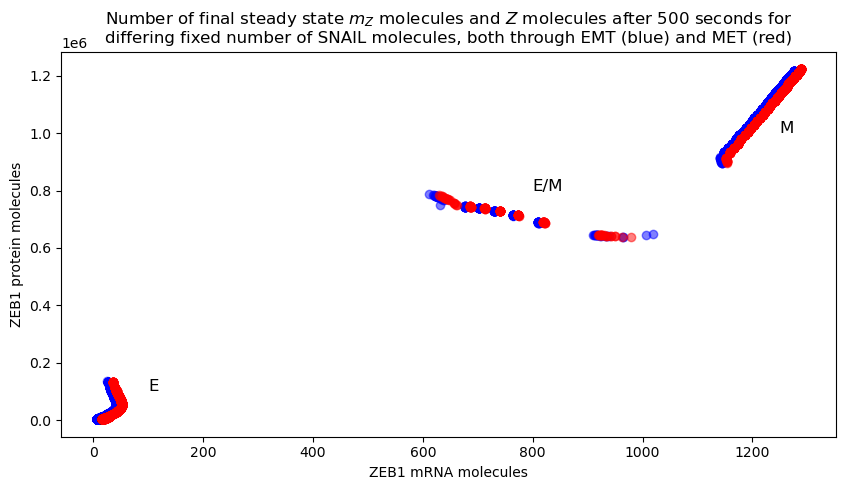

In [5]:
SNAIL = np.concatenate((np.linspace(0,300000,100), np.linspace(300000,0,100)))

#Similar to the previous cell
plt.figure(figsize=(10,5))
colour = "blue"
shift = 0
for s in SNAIL:
    params[-3] = s
    for i in range(20):
        #Changing the initial number of molecules of the variables slightly \
        #randomly to identify convergences of steady state number of molecules of \
        #mZ and how this different with Z
        y0 = rng.random(5)*[200000, 20000, 15000, 20000, 15000]
        y = odeint(model, y0, t, args=(params,))
        #Extracting both the final steady state number of molecules of both mZ and \
        #Z after 500 seconds
        mZ = y[:,1][-1]
        Z = y[:,2][-1]
        if s == 300000:
            colour = "red"
            #Introducing a shift to be able to view overlapping points
            shift = 10
        plt.plot(mZ+shift, Z, 'o', color=colour, alpha = 0.5)

plt.xlabel("ZEB1 mRNA molecules")
plt.ylabel("ZEB1 protein molecules")
plt.text(100, 0.1e6, 'E', fontsize=12)
plt.text(800, 0.8e6, 'E/M', fontsize=12)
plt.text(1250, 1e6, 'M', fontsize=12)
plt.title("Number of final steady state $m_Z$ molecules and $Z$ molecules after \
500 seconds for \ndiffering fixed number of SNAIL molecules, both through EMT \
(blue) and MET (red)")
plt.show()

### Creating a genetic algorithm to optimise the degradation and translation rates matrix parameters

In [6]:
#Setting the target amounts of mZ for the each of the 200 amounts of SNAIL \
#molecules taken
target_molecules = np.empty(200)
#E state
target_molecules[:61] = 50
#E/M state (after EMT)
target_molecules[61:67] = 500
#M state (after EMT)
target_molecules[67:146] = 1200
#E state (after MET)
target_molecules[146:] = 50

#Function to extract the final 200 number of molecules of ZEB1 mRNA over number of \
#molecules of SNAIL form 0 to 300000 back down to 0
def solve(M):
    y0 = [200000, 20000, 15000, 20000, 15000]
    t = np.linspace(0, 500, 10000)
    params = [2100, 0.05, 11, 0.5, 100, 0.1, 11, 0.2, 300, 0.1, 0.1, 3, 220000, \
              0.1, 2, 180000, 10, 2, 180000, 10000, 6, 0.1, 2, 20000, 10, 1, \
              20000, 2, 15000, 190000, 400000, M]
    SNAIL = np.concatenate((np.linspace(0,300000,100), np.linspace(300000,0,100)))
    observed_molecules = []
    for s in SNAIL:
        params[-3] = s
        y = odeint(model, y0, t, args=(params,))
        mZ = y[:,1][-1]
        y0 = y[-1]
        observed_molecules.append(mZ)
    return observed_molecules

#Function to calculate the sum of squared errors between the observed number of \
#molecules of ZEB1 mRNA and the target amount of molecules
def cost(observed):
    errors = np.sum((target_molecules - observed)**2)
    return errors

In [7]:
#Genetic algorithm function to slightly alter the guess rates matrix and determine \
#the new best fit
def genetic_algorithm(guess, n):
    all_costs = []
    best_child = np.array(guess)
    
    for m in range(n):
        #Re-initialising the current list of rates matrices to either be the \
        #initial guess or the updated best child rates matrix
        guess_children = []
        guess_children.append(best_child)
        for i in range(5):
            #Adding 5 rate matrices to the list that have random slight alteration \
            #to each parameter
            guess_alteration = best_child + np.random.uniform(-0.05, 0.05, \
                                                              best_child.shape)
            guess_children.append(np.absolute(guess_alteration))
        #Also adding a completely new matrix of rate parameters to try combat an \
        #error local minimum
        random_matrix = rng.random(21).reshape(3,7)
        guess_children.append(random_matrix)
        
        #Joining all cost/errors of each matrix into a list
        all_costs = list(map(lambda x: cost(solve(x)), guess_children))
        #Finding the index corresponding to the lowest cost/error from the list
        index = all_costs.index(min(all_costs))
        #Finding the rate matrix that corresponds to the lowest cost/error
        best_child = np.array(guess_children[index])
        print(f"Progress: {m+1}/{n}. Current cost: {all_costs[index]:.2f}")
    
    #After n iterations, returns the best rate matrix that minimises cost/error \
    #from the target number of ZEB1 mRNA at each amount of SNAIL
    return best_child

In [ ]:
genetic_algorithm(rates_matrix, 1000)
#The output is then tested in the cell much above to replot number of variable \
#molecules over time and bifurcation diagram till the expected diagram is achieved

## Altering the system model by removing ESRP1

In [8]:
#Defining the new model function
def new_model(y, t, params):
    
    #Current concentrations of each dynamic component of the model (starts off as \
    #the initial concentration when the function is called)
    μ_200, m_Z, Z = y
    
    #Fixed parameters of the model
    (g_μ200, k_μ200, g_mZ, k_mZ, g_Z, k_Z, g_mE, k_mE, g_E, k_E,
     λ_Z_μ200, n_Z_μ200, Z0_μ200, λ_S_μ200, n_S_μ200, S0_μ200,
     λ_S_mZ, n_S_mZ, S0_mZ, μ0, n_μ200,
     Z0_mZ, n_Z_mZ, λ_Z_mZ, S, rates) = params
    
    #Shifted hill function
    def H(B, B0, n, λ):
        return (1 + λ*(B/B0)**n) / (1 + (B/B0)**n)
    
    #Function for calculating translation rate, mRNA active degradation rate, and \
    #microRNA active degrataion rate
    def Y(μ, n, l):
        rate = 0
        
        #Looping through each number of binding sites occupied (including 0)
        for i in range(n+1):
            
            #Summation of the total rate, taking into account the rate at each \
            #number of binding sites and combinations of the binding sites
            rate += l[i] * math.comb(n, i) * (μ/μ0)**i
            
        #Returning the total rate summed
        return rate / (1 + (μ/μ0)**n)
    
    dydt = np.empty(len(y))
    #mircoRNA miR-200 
    dydt[0] = g_μ200 * H(Z, Z0_μ200, n_Z_μ200, λ_Z_μ200) * H(S, S0_μ200, n_S_μ200, \
              λ_S_μ200) - m_Z * Y(μ_200, n_μ200, rates[0]) - k_μ200 * μ_200
    #ZEB1 mRNA 
    dydt[1] = g_mZ * H(S, S0_mZ, n_S_mZ, λ_S_mZ) * H(Z, Z0_mZ, n_Z_mZ, λ_Z_mZ) \
              - m_Z * Y(μ_200, n_μ200, rates[1]) - k_mZ * m_Z 
    #ZEB1 protein 
    dydt[2] = g_Z * m_Z * Y(μ_200, n_μ200, rates[2]) - k_Z * Z 
    #Removed differential equations for ESPR1 protein and mRNA
    
    return dydt

### Plotting variable number of molecules over time

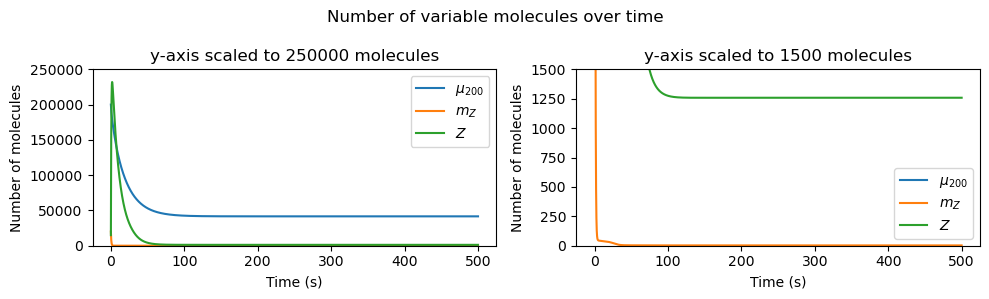

In [9]:
#Setting initial variable number of molecules and time space of 500s
new_y0 = [200000, 20000, 15000]
t = np.linspace(0, 500, 10000)

#Using the same rates matrix for degradation & translation rate parameters \
#(dependent on miR-200 and ZEB1 mRNA complex) as optimised for the original model 
new_rates_matrix = [[0.2072836 , 0.00531038, 0.21246182, 0.45427178, 0.58466384, \
        0.68420842, 0.45821863],
       [0.3521301 , 0.25882117, 0.29449745, 0.67784164, 1.36551406, \
        1.10574912, 0.86266633], 
       [1.12367425, 0.6145642 , 0.52844913, 0.16996539, 0.1007383 , \
        0.07068439, 0.20191021]]
 
#Initial guesses for the 3 parameters
first_Z_mZ_guess = [200000, 2, 1]
#Updated guess after 1000 steps of the genetic algorithm below
middle_Z_mZ_guess = [59403.91595106, 3.16243615, 5.99105754]

#Updated guess from the genetic algorithm below
Z_mZ_guess = [27593.52387262, 3.37289374, 6.99761348]
Z_mZ_0, Z_mZ_n, Z_mZ_λ = Z_mZ_guess

#Inputting the parameter guesses for modelling ZEB1 self-activation amongst other \
#parameters
new_params = [2100, 0.05, 11, 0.5, 100, 0.1, 11, 0.2, 300, 0.1, 0.1, 3, 220000, \
              0.1, 2, 180000, 10, 2, 180000, 10000, 6, Z_mZ_0, Z_mZ_n, Z_mZ_λ, \
              15000, new_rates_matrix]
new_concs = odeint(new_model, new_y0, t, args=(new_params,))

plt.figure(figsize=(10,3))
zooms = [250000, 1500]
for i in range(2):
    plt.subplot(1,2,i+1)
    plt.plot(t, new_concs[:,0], label="$μ_{200}$")
    plt.plot(t, new_concs[:,1], label="$m_Z$")
    plt.plot(t, new_concs[:,2], label="$Z$")
    plt.legend()
    plt.xlabel("Time (s)")
    plt.ylabel("Number of molecules")
    plt.ylim(0, zooms[i])
    plt.title(f"y-axis scaled to {zooms[i]} molecules")
plt.suptitle(f"Number of variable molecules over time")
plt.tight_layout()
plt.show()

### Plotting bifurcation diagrams of the new model with initial and optimised ZEB1 self-activation parameters

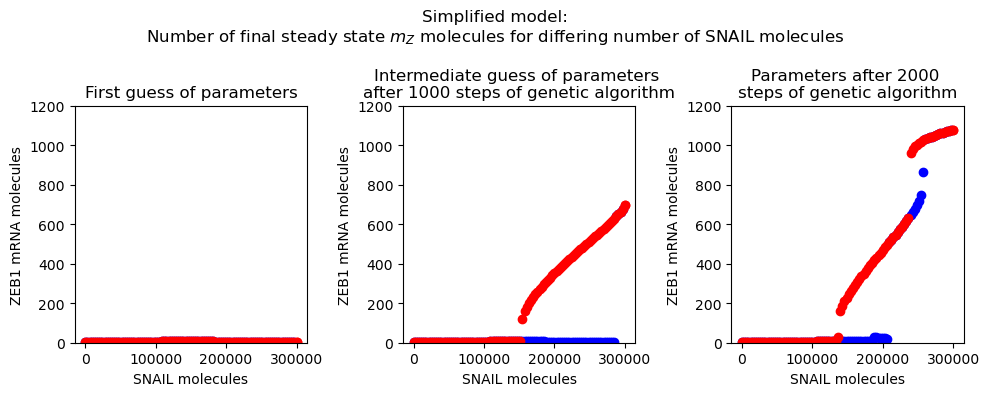

In [10]:
#Setting the amount of SNAIL molecules to increase from 0 to 300000 and back down \
#to simulate EMT followed by MET
SNAIL = np.concatenate((np.linspace(0,300000,100), np.linspace(300000,0,100)))

plt.figure(figsize=(10,4))

#Storing the first guess and final optimised parameters of ZEB1 self-activation
comparison_Z_mZ_params = [first_Z_mZ_guess, middle_Z_mZ_guess, Z_mZ_guess]

for i in range(3):
    plt.subplot(1,3,i+1)
        
    colour = "blue"
        
    #Introducing a shift to be able to more clearly see the overlapping data \
    #points
    shift = 0
    
    Z_mZ_0, Z_mZ_n, Z_mZ_λ = comparison_Z_mZ_params[i]
    
    new_params = [2100, 0.05, 11, 0.5, 100, 0.1, 11, 0.2, 300, 0.1, 0.1, 3, \
                  220000, 0.1, 2, 180000, 10, 2, 180000, 10000, 6, Z_mZ_0, \
                  Z_mZ_n, Z_mZ_λ, 15000, new_rates_matrix]
    
    for s in SNAIL:
        #Resetting the amount of SNAIL molecules in the parameter list
        new_params[-2] = s
        new_y = odeint(new_model, new_y0, t, args=(new_params,))
        #Extracting the final number of molecules of ZEB1 mRNA at the steady \
        #state at 500 seconds
        new_mZ = new_y[:,1][-1]
        #Updating the new "initial" number of molecules of the variables
        new_y0 = new_y[-1]
        #Changing colour of the plotted dots to identify when EMT is switching \
        #to MET
        if s == 300000:
            colour = "red"
            #Making the shift bigger than 0 to more clearly see the overlapping \
            #data points
        plt.plot(s, new_mZ, 'o', color = colour)
    plt.xlabel("SNAIL molecules")
    plt.ylabel("ZEB1 mRNA molecules")
    plt.ylim(0, 1200)
    
plt.subplot(1,3,1)
plt.title("First guess of parameters")
plt.subplot(1,3,2)
plt.title("Intermediate guess of parameters \nafter 1000 steps of genetic \
algorithm")
plt.subplot(1,3,3)
plt.title("Parameters after 2000 \nsteps of genetic algorithm")
plt.suptitle("Simplified model:\nNumber of final steady state $m_Z$ molecules for \
differing number of SNAIL molecules")
plt.tight_layout()
plt.show()

### Altering the genetic algorithm functions to optimise ZEB1 self-activation parameters

In [11]:
#Function to extract the final 200 number of molecules of ZEB1 mRNA over number of \
#molecules of SNAIL form 0 to 300000 back down to 0
def new_solve(A):
    new_y0 = [200000, 20000, 15000]
    t = np.linspace(0, 500, 10000)
    new_rates_matrix = [[0.2072836 , 0.00531038, 0.21246182, 0.45427178, \
        0.58466384, 0.68420842, 0.45821863],
       [0.3521301 , 0.25882117, 0.29449745, 0.67784164, 1.36551406, \
        1.10574912, 0.86266633],
       [1.12367425, 0.6145642 , 0.52844913, 0.16996539, 0.1007383 , \
        0.07068439, 0.20191021]]
    Z_mZ_0, Z_mZ_n, Z_mZ_λ = A
    new_params = [2100, 0.05, 11, 0.5, 100, 0.1, 11, 0.2, 300, 0.1, 0.1, 3, \
                  220000, 0.1, 2, 180000, 10, 2, 180000, 10000, 6, Z_mZ_0, \
                  Z_mZ_n, Z_mZ_λ, 15000, new_rates_matrix]
    SNAIL = np.concatenate((np.linspace(0,300000,100), np.linspace(300000,0,100)))
    observed_molecules = []
    for s in SNAIL:
        params[-2] = s
        new_y = odeint(new_model, new_y0, t, args=(new_params,))
        new_mZ = new_y[:,1][-1]
        new_y0 = new_y[-1]
        observed_molecules.append(new_mZ)
    return observed_molecules

In [12]:
#Genetic algorithm function to slightly alter the guess parameters for activation \
#of ZEB1 self-activation and determine the new best fit
def new_genetic_algorithm(guess, n):
    all_costs = []
    global best_child
    best_child = np.array(guess)
    
    for m in range(n):
        #Re-initialising the current list of paramter array to either be the \
        #initial guess or the updated best child array
        guess_children = []
        guess_children.append(best_child)
        for i in range(5):
            #Adding 5 arrays to the list that each have random slight alteration \
            #to the original parameter array
            guess_alteration = best_child + np.array([np.random.uniform(-10000, \
                               10000), np.random.uniform(-0.5, 0.5), \
                               np.random.uniform(-0.5, 0.5)])
            guess_children.append(np.absolute(guess_alteration))
        #Also adding a completely new array of parameters to try combat an error \
        #local minimum
        random_matrix = np.array([np.random.uniform(0, 300000), \
                                  np.random.uniform(0, 15), \
                                  np.random.uniform(0, 15)])
        guess_children.append(random_matrix)
        
        #Joining all cost/errors of each array into a list
        all_costs = list(map(lambda x: cost(new_solve(x)), guess_children))
        #Finding the index corresponding to the lowest cost/error from the list
        index = all_costs.index(min(all_costs))
        #Finding the parameter array that corresponds to the lowest cost/error
        best_child = np.array(guess_children[index])
        print(f"Progress: {m+1}/{n}. Current cost: {all_costs[index]:.2f}")
    
    #After n iterations, returns the best parameter array that minimises \
    #cost/error from the target number of ZEB1 mRNA at each amount of SNAIL
    return best_child

In [ ]:
new_genetic_algorithm(Z_mZ_guess, 1000)